# 简介

此baseline分数0.697左右

# 工具包导入&数据读取

## 工具包导入

In [1]:
import numpy as np
import pandas as pd
import lightgbm as lgb
import os

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

from tqdm import tqdm
###########################

import json 
from sklearn.metrics import f1_score
from sklearn.model_selection import StratifiedKFold
from itertools import product
import ast
pd.set_option('display.max_columns',None)

In [2]:
lgb.__version__

'3.3.2'

In [3]:
path = "./kdd2019/data/"

train_queries = pd.read_csv(path + 'train_queries_phase2.csv', parse_dates=['req_time'],nrows=1000)
train_plans   = pd.read_csv(path + 'train_plans_phase2.csv', parse_dates=['plan_time'])
train_clicks  = pd.read_csv(path + 'train_clicks_phase2.csv')
profiles      = pd.read_csv(path + 'profiles.csv') 

test_queries  = pd.read_csv(path + 'test_queries.csv', parse_dates=['req_time'])
test_plans    = pd.read_csv(path + 'test_plans.csv', parse_dates=['plan_time'])

In [4]:
train_queries.shape

(1000, 5)

In [37]:
test_queries.shape

(304916, 5)

In [38]:
test_plans.shape

(296483, 3)

In [5]:
train_queries.head()

,sid,pid,req_time,o,d
0,1972109,NaN,2018-11-15 18:42:55,"114.12,22.55","114.09,22.57"
1,1684471,17261.0,2018-11-17 14:45:45,"113.84,22.81","113.84,22.80"
2,702620,NaN,2018-10-06 22:14:36,"121.51,31.23","121.50,31.24"
3,1255247,6784.0,2018-11-10 17:46:42,"113.31,23.11","113.30,23.15"
4,1374354,11803.0,2018-11-11 14:05:27,"113.26,23.14","113.30,23.10"


In [6]:
train_plans.head()

,sid,plan_time,plans
0,955169,2018-10-20 20:23:55,"[{""distance"": 10148, ""price"": 600, ""eta"": 2927..."
1,1262759,2018-11-09 13:16:11,"[{""distance"": 11372, ""price"": 200, ""eta"": 3325..."
2,1579883,2018-10-27 22:19:21,"[{""distance"": 823, ""price"": """", ""eta"": 794, ""t..."
3,739077,2018-10-19 13:34:15,"[{""distance"": 32250, ""price"": 1400, ""eta"": 608..."
4,1048542,2018-10-03 12:43:35,"[{""distance"": 1083, ""price"": """", ""eta"": 927, ""..."


In [7]:
train_clicks.head()

,sid,click_time,click_mode
0,685277,2018-10-20 12:41:35,1
1,721856,2018-10-12 23:02:36,9
2,1970650,2018-10-11 20:49:15,2
3,1391814,2018-11-29 11:11:35,1
4,1094883,2018-11-30 22:51:58,2


In [8]:
profiles.head()

,pid,p0,p1,p2,p3,p4,p5,p6,p7,p8,p9,p10,p11,p12,p13,p14,p15,p16,p17,p18,p19,p20,p21,p22,p23,p24,p25,p26,p27,p28,p29,p30,p31,p32,p33,p34,p35,p36,p37,p38,p39,p40,p41,p42,p43,p44,p45,p46,p47,p48,p49,p50,p51,p52,p53,p54,p55,p56,p57,p58,p59,p60,p61,p62,p63,p64,p65
0,20555,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,42213,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,29526,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,117756,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,185606,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0


# 特征工程
- 此处我们对所有表格进行合并,这样方便提取表格之间的交互特征,注意因为初赛的数据相对较少,所以我们才合在一起,不然尽量不要做,这样会给机器的内存带来非常大的负担.

## 数据集合并

In [9]:
train = train_queries.merge(train_plans, "left", ["sid"])
test  = test_queries.merge(test_plans, 'left', ['sid'])

# train三种数据合并到一起
train = train.merge(train_clicks, "left", ["sid"])
train["click_mode"] = train["click_mode"].fillna(0).astype(int)

data = pd.concat([train, test], ignore_index=True)

data = data.merge(profiles, "left", ["pid"])

In [10]:
test.head()

,sid,pid,req_time,o,d,plan_time,plans
0,2068451,NaN,2018-12-05 14:00:11,"116.15,39.73","116.38,39.96",2018-12-05 14:00:11,"[{""distance"": 42500, ""price"": """", ""eta"": 3811,..."
1,2293651,22317.0,2018-12-03 12:38:59,"113.93,22.53","113.97,22.55",2018-12-03 12:38:59,"[{""distance"": 8733, ""price"": """", ""eta"": 3142, ..."
2,2121308,NaN,2018-12-03 17:08:58,"121.53,31.23","121.52,31.24",2018-12-03 17:08:58,"[{""distance"": 1995, ""price"": 300, ""eta"": 1235,..."
3,2086760,57077.0,2018-12-07 17:51:36,"116.36,39.83","116.41,39.84",2018-12-07 17:51:36,"[{""distance"": 5623, ""price"": 300, ""eta"": 1535,..."
4,2103547,53986.0,2018-12-03 11:30:59,"121.40,31.20","121.40,31.21",2018-12-03 11:30:59,"[{""distance"": 2724, ""price"": 200, ""eta"": 1864,..."


In [11]:
test.shape

(304916, 7)

In [12]:
train.head()

,sid,pid,req_time,o,d,plan_time,plans,click_time,click_mode
0,1972109,NaN,2018-11-15 18:42:55,"114.12,22.55","114.09,22.57",2018-11-15 18:42:55,"[{""distance"": 6238, ""price"": 300, ""eta"": 1713,...",2018-11-15 18:43:31,1
1,1684471,17261.0,2018-11-17 14:45:45,"113.84,22.81","113.84,22.80",2018-11-17 14:45:45,"[{""distance"": 527, ""price"": """", ""eta"": 450, ""t...",2018-11-17 14:45:51,5
2,702620,NaN,2018-10-06 22:14:36,"121.51,31.23","121.50,31.24",2018-10-06 22:14:36,"[{""distance"": 2243, ""price"": 300, ""eta"": 1027,...",2018-10-06 22:15:31,2
3,1255247,6784.0,2018-11-10 17:46:42,"113.31,23.11","113.30,23.15",2018-11-10 17:46:42,"[{""distance"": 8485, ""price"": 300, ""eta"": 1823,...",2018-11-10 17:46:55,9
4,1374354,11803.0,2018-11-11 14:05:27,"113.26,23.14","113.30,23.10",2018-11-11 14:05:27,"[{""distance"": 8753, ""price"": 400, ""eta"": 1519,...",2018-11-11 14:05:30,2


## od(经纬度)特征

- 因为经纬度是组合字符串特征,此处对其进行还原,因为o,d本身是有相对大小关系的,不再对其进行编码。

In [13]:
data["o_lng"] = data["o"].apply(lambda x: float(x.split(",")[0]))
data["o_lat"] = data["o"].apply(lambda x: float(x.split(",")[0]))
data["d_lng"] = data["d"].apply(lambda x: float(x.split(",")[0]))
data["d_lat"] = data["d"].apply(lambda x: float(x.split(",")[0]))

## plan_time & req_time特征

### 原始特征
时间信息会影响我们的决定,比如大晚上从A地到B地其实很多人是不会选择步行的,更多的会选择打车之类的,因为太黑了,怕迷路等;而如果是早高峰,而且离公司就几公里的情况, 那么一般就不会打车，因为特别会容易堵车,这个时候大家更喜欢骑自行车.
- 此处我们提取weekday来标志是周几; hour来标志是当日几点.

In [14]:
time_feature = []
for i in ["req_time"]:
    data[i + "_hour"] = data[i].dt.hour
    data[i + "_weekday"] = data[i].dt.weekday
    time_feature.append(i + "_hour")
    time_feature.append(i + "_weekday")

In [15]:
# data.head()

### plan_time & req_time差值特征

我们做EDA的时候发现plan_time和req_time并不是完全一样的,有的有一些时间差,猜测可能是手机的网速等问题,所以我们做差值来标志用户的手机信号等信息.

In [16]:
data["time_diff"] = (pd.to_datetime(data["plan_time"]) - pd.to_datetime(data["req_time"])).dt.days
time_feature.append("time_diff")

In [17]:
# data['time_diff'].head()
# data["time_diff"].value_counts()

## plans特征

plans这个数据集包含的信息非常多,因为这个信息是基于百度地图推荐的。所以毫无疑问是本次比赛的关键之一,我们对其进行展开并提取相关的特征。

此处我发现kdd已经有大佬开源了plans的特征提取关键代码,我感觉很不错,此处我便直接引用,至于其他的特征欢迎去作者的Github下载.

此处关于plans的特征主要可以归纳为如下的特征:

1. 百度地图推荐的距离的统计值(mean,min,max,std)
2. 各种交通方式的价格的统计值(mean,min,max,std)
3. 各种交通方式的时间的统计值(mean,min,max,std)
4. 一些其他的特征,最大距离的交通方式,最高价格的交通方式,最短时间的交通方式等.

In [18]:
data["plans_json"] = data["plans"].fillna("[]").apply(ast.literal_eval)

In [19]:
data["plans_json"].head()

0    [{'distance': 6238, 'price': 300, 'eta': 1713,...
1    [{'distance': 527, 'price': '', 'eta': 450, 't...
2    [{'distance': 2243, 'price': 300, 'eta': 1027,...
3    [{'distance': 8485, 'price': 300, 'eta': 1823,...
4    [{'distance': 8753, 'price': 400, 'eta': 1519,...
Name: plans_json, dtype: object

In [20]:
# 计划数量最多的数量
print(data["plans_json"].apply(len).max())

8


In [21]:
# 4 * 8个新特征
rank_feature = []
for i in range(data["plans_json"].apply(len).max()):
    rank_feature.append("price_" + str(i))
    rank_feature.append("eta_" + str(i))
    rank_feature.append("distance_" + str(i))
    # transport_mode
    data["rank_" + str(i)] = data["plans_json"].apply(lambda x: x[i]["transport_mode"] if len(x) > i else None)
    # price
    data['price_' + str(i)]    = data['plans_json'].apply(lambda x: x[i]['price'] if len(x) > i else None)
    data['price_' + str(i)]    = data['price_' + str(i)].apply(lambda x: 0 if x == ''or x is None else float(x))
    # eta
    data['eta_' + str(i)]      = data['plans_json'].apply(lambda x: x[i]['eta'] if len(x) > i else None)
    # distance
    data['distance_' + str(i)] = data['plans_json'].apply(lambda x: x[i]['distance'] if len(x) > i else None)
    if i == 0:
        continue
    rank_feature.append("rank_" + str(i))

In [22]:
data.shape

(305916, 115)

In [23]:
data.head()

,sid,pid,req_time,o,d,plan_time,plans,click_time,click_mode,p0,p1,p2,p3,p4,p5,p6,p7,p8,p9,p10,p11,p12,p13,p14,p15,p16,p17,p18,p19,p20,p21,p22,p23,p24,p25,p26,p27,p28,p29,p30,p31,p32,p33,p34,p35,p36,p37,p38,p39,p40,p41,p42,p43,p44,p45,p46,p47,p48,p49,p50,p51,p52,p53,p54,p55,p56,p57,p58,p59,p60,p61,p62,p63,p64,p65,o_lng,o_lat,d_lng,d_lat,req_time_hour,req_time_weekday,time_diff,plans_json,rank_0,price_0,eta_0,distance_0,rank_1,price_1,eta_1,distance_1,rank_2,price_2,eta_2,distance_2,rank_3,price_3,eta_3,distance_3,rank_4,price_4,eta_4,distance_4,rank_5,price_5,eta_5,distance_5,rank_6,price_6,eta_6,distance_6,rank_7,price_7,eta_7,distance_7
0,1972109,NaN,2018-11-15 18:42:55,"114.12,22.55","114.09,22.57",2018-11-15 18:42:55,"[{""distance"": 6238, ""price"": 300, ""eta"": 1713,...",2018-11-15 18:43:31,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,114.12,114.12,114.09,114.09,18,3,0.0,"[{'distance': 6238, 'price': 300, 'eta': 1713,...",9.0,300.0,1713.0,6238.0,3.0,0.0,862.0,5864.0,4.0,2200.0,1102.0,5864.0,6.0,0.0,1304.0,4323.0,1.0,200.0,1883.0,5711.0,2.0,300.0,1914.0,6237.0,5.0,0.0,3725.0,4186.0,NaN,0,NaN,NaN
1,1684471,17261.0,2018-11-17 14:45:45,"113.84,22.81","113.84,22.80",2018-11-17 14:45:45,"[{""distance"": 527, ""price"": """", ""eta"": 450, ""t...",2018-11-17 14:45:51,5.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,113.84,113.84,113.84,113.84,14,5,0.0,"[{'distance': 527, 'price': '', 'eta': 450, 't...",5.0,0.0,450.0,527.0,6.0,0.0,261.0,872.0,3.0,0.0,310.0,1214.0,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0,NaN,NaN
2,702620,NaN,2018-10-06 22:14:36,"121.51,31.23","121.50,31.24",2018-10-06 22:14:36,"[{""distance"": 2243, ""price"": 300, ""eta"": 1027,...",2018-10-06 22:15:31,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,121.51,121.51,121.50,121.50,22,5,0.0,"[{'distance': 2243, 'price': 300, 'eta': 1027,...",2.0,300.0,1027.0,2243.0,3.0,0.0,609.0,2539.0,4.0,1400.0,789.0,2539.0,1.0,200.0,1523.0,2477.0,5.0,0.0,1796.0,1889.0,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0,NaN,NaN
3,1255247,6784.0,2018-11-10 17:46:42,"113.31,23.11","113.30,23.15",2018-11-10 17:46:42,"[{""distance"": 8485, ""price"": 300, ""eta"": 1823,...",2018-11-10 17:46:55,9.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,113.31,113.31,113.30,113.30,17,5,0.0,"[{'distance': 8485, 'price': 300, 'eta': 1823,...",9.0,300.0,1823.0,8485.0,3.0,0.0,1453.0,7197.0,4.0,3600.0,1693.0,7197.0,6.0,0.0,1860.0,6168.0,2.0,300.0,2165.0,15580.0,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0,NaN,NaN
4,1374354,11803.0,2018-11-11 14:05:27,"113.26,23.14","113.30,23.10",2018-11-11 14:05:27,"[{""distance"": 8753, ""price"": 400, ""eta"": 1519,...",2018-11-11 14:05:30,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,113.26,113.26,113.30,113.30,14,6,0.0,"[{'distance': 8753, 'price': 400, 'eta': 1519,...",2.0,400.0,1519.0,8753.0,3.0,0.0,1645.0,9032.0,4.0,3500.0,1945.0,9032.0,6.0,0.0,2667.0,8833.0,NaN,0.0,NaN,N

In [24]:
# argsort()是将X中的元素从小到大排序后，提取对应的索引index，然后输出到y

In [25]:
X = [8,6,9,1,3]
np.argsort(X)

array([3, 4, 1, 0, 2], dtype=int64)

In [26]:
def gen_plan_feas(data):
    # 数据大小
    n                                           = data.shape[0]
    # 交通方式的种类
    mode_list_feas                              = np.zeros((n, 12))
    # 各类交通方式的距离统计值
    max_dist, min_dist, mean_dist, std_dist     = np.zeros((n,)), np.zeros((n,)), np.zeros((n,)), np.zeros((n,))
    # 各类交通方式的价格统计值
    max_price, min_price, mean_price, std_price = np.zeros((n,)), np.zeros((n,)), np.zeros((n,)), np.zeros((n,))
    # 各类交通方式的时间统计值
    max_eta, min_eta, mean_eta, std_eta         = np.zeros((n,)), np.zeros((n,)), np.zeros((n,)), np.zeros((n,))
    # 最大距离的交通方式，最高价格的交通方式等等
    min_dist_mode, max_dist_mode, min_price_mode, max_price_mode, min_eta_mode, max_eta_mode, first_mode = \
    np.zeros((n,)), np.zeros((n,)), np.zeros((n,)), np.zeros((n,)), np.zeros((n,)), np.zeros((n,)), np.zeros((n,))
  
    mode_texts = []
    for i, plan in tqdm(enumerate(data['plans_json'].values)):
        if len(plan) == 0:
            cur_plan_list   = []
        else:
            cur_plan_list   = plan
        # 无交通方式计划时
        if len(cur_plan_list) == 0:
            mode_list_feas[i, 0] =  1
            first_mode[i]        =  0

            max_dist[i]          = -1
            min_dist[i]          = -1
            mean_dist[i]         = -1
            std_dist[i]          = -1

            max_price[i]         = -1
            min_price[i]         = -1
            mean_price[i]        = -1
            std_price[i]         = -1

            max_eta[i]           = -1
            min_eta[i]           = -1
            mean_eta[i]          = -1
            std_eta[i]           = -1

            min_dist_mode[i]     = -1
            max_dist_mode[i]     = -1
            min_price_mode[i]    = -1
            max_price_mode[i]    = -1
            min_eta_mode[i]      = -1
            max_eta_mode[i]      = -1

            mode_texts.append('word_null')
        else: # 有交通方式计划时
            distance_list = []
            price_list = []
            eta_list = []
            mode_list = []
            for tmp_dit in cur_plan_list:
                distance_list.append(int(tmp_dit['distance']))
                if tmp_dit['price'] == '': # 价格为空时，填充0
                    price_list.append(0)
                else:
                    price_list.append(int(tmp_dit['price']))
                eta_list.append(int(tmp_dit['eta']))
                mode_list.append(int(tmp_dit['transport_mode']))
            # 交通方式文本表示
            mode_texts.append(
                ' '.join(['word_{}'.format(mode) for mode in mode_list]))
            # 每个请求给出的全部计划(plans)
            distance_list                = np.array(distance_list)
            price_list                   = np.array(price_list)
            eta_list                     = np.array(eta_list)
            mode_list                    = np.array(mode_list, dtype='int')
            mode_list_feas[i, mode_list] = 1
            # 从小到大排序后，按照位置返回原数据的索引
            distance_sort_idx            = np.argsort(distance_list)
            price_sort_idx               = np.argsort(price_list)
            eta_sort_idx                 = np.argsort(eta_list)
            # 获取距离统计值
            max_dist[i]                  = distance_list[distance_sort_idx[-1]]
            min_dist[i]                  = distance_list[distance_sort_idx[0]]
            mean_dist[i]                 = np.mean(distance_list)
            std_dist[i]                  = np.std(distance_list)
            # 获取价格统计值
            max_price[i]                 = price_list[price_sort_idx[-1]]
            min_price[i]                 = price_list[price_sort_idx[0]]
            mean_price[i]                = np.mean(price_list)
            std_price[i]                 = np.std(price_list)
            # 获取时间统计值
            max_eta[i]                   = eta_list[eta_sort_idx[-1]]
            min_eta[i]                   = eta_list[eta_sort_idx[0]]
            mean_eta[i]                  = np.mean(eta_list)
            std_eta[i]                   = np.std(eta_list)
            # 交通方式
            # 第一个推荐的交通方式
            first_mode[i]                = mode_list[0]
            # 最大最小距离的交通方式
            max_dist_mode[i]             = mode_list[distance_sort_idx[-1]]
            min_dist_mode[i]             = mode_list[distance_sort_idx[0]]
            # 最大最小价格的交通方式
            max_price_mode[i]            = mode_list[price_sort_idx[-1]]
            min_price_mode[i]            = mode_list[price_sort_idx[0]]
            # 最大最小时间的交通方式
            max_eta_mode[i]              = mode_list[eta_sort_idx[-1]]
            min_eta_mode[i]              = mode_list[eta_sort_idx[0]]
    # 特征数据
    feature_data                   =  pd.DataFrame(mode_list_feas)  # shape (n, 12)
    feature_data.columns           =  ['mode_feas_{}'.format(i) for i in range(12)]
    feature_data['max_dist']       =  max_dist
    feature_data['min_dist']       =  min_dist
    feature_data['mean_dist']      =  mean_dist
    feature_data['std_dist']       =  std_dist

    feature_data['max_price']      = max_price
    feature_data['min_price']      = min_price
    feature_data['mean_price']     = mean_price
    feature_data['std_price']      = std_price

    feature_data['max_eta']        = max_eta
    feature_data['min_eta']        = min_eta
    feature_data['mean_eta']       = mean_eta
    feature_data['std_eta']        = std_eta

    feature_data['max_dist_mode']  = max_dist_mode
    feature_data['min_dist_mode']  = min_dist_mode
    feature_data['max_price_mode'] = max_price_mode
    feature_data['min_price_mode'] = min_price_mode
    feature_data['max_eta_mode']   = max_eta_mode
    feature_data['min_eta_mode']   = min_eta_mode
    feature_data['first_mode']     = first_mode
    print('mode tfidf...')
    # tfidf
    tfidf_enc = TfidfVectorizer(ngram_range=(1, 2))
    tfidf_vec = tfidf_enc.fit_transform(mode_texts)
    # 奇异值分解(10)
    svd_enc = TruncatedSVD(n_components=10, n_iter=20, random_state=2019)
    mode_svd = svd_enc.fit_transform(tfidf_vec)
    mode_svd = pd.DataFrame(mode_svd)
    mode_svd.columns = ['svd_mode_{}'.format(i) for i in range(10)]

    plan_fea = pd.concat([feature_data, mode_svd], axis=1)
    plan_fea['sid'] = data['sid'].values
    return plan_fea

In [31]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD

data_plans = gen_plan_feas(data)
plan_features = [col for col in data_plans.columns if col not in ["sid"]]
print(len(plan_features))
data = data.merge(data_plans, how="left", on="sid")

305916it [00:50, 6044.33it/s]


mode tfidf...
41


# 模型训练&验证&提交
## 模型训练&验证

### 评估指标设计
- 为了对线上线下有一定的了解,我们尽可能设计和线上一样的评估,下面是lgb的评估函数

In [32]:
def f1_weighted(labels,preds):
    preds = np.argmax(preds.reshape(12, -1), axis=0)
    score = f1_score(y_true=labels, y_pred=preds, average='weighted')
    return 'f1_weighted', score, True

### 模型验证
- 此处我们模拟线上,选用7天的时间作为验证集.

In [33]:
# pid缺失值填充-1
data['pid'] = data['pid'].fillna(-1).astype(int)

In [76]:
%%time
profile_feature    = ['p' + str(i) for i in range(66)]
origin_num_feature = ['o_lng', 'o_lat', 'd_lng', 'd_lat'] + profile_feature
cate_feature       = ['pid']  
feature            = origin_num_feature + cate_feature + plan_features + time_feature + rank_feature
# 训练集
train_index = (data.req_time < '2018-11-23')
train_x     = data[train_index][feature].reset_index(drop=True)
train_y     = data[train_index].click_mode.reset_index(drop=True)
# 验证集
valid_index = (data.req_time > '2018-11-23') & (data.req_time < '2018-12-01')
valid_x     = data[valid_index][feature].reset_index(drop=True)
valid_y     = data[valid_index].click_mode.reset_index(drop=True)
# 测试集
test_index = (data.req_time > '2018-12-01')
test_x     = data[test_index][feature].reset_index(drop=True)

print(len(feature), feature)
lgb_model = lgb.LGBMClassifier(boosting_type="gbdt", num_leaves=61, reg_alpha=0, reg_lambda=0.01,
    max_depth=-1, n_estimators=2000, objective='multiclass',
    subsample=0.8, colsample_bytree=0.8, subsample_freq=1,min_child_samples = 50,
    learning_rate=0.05, random_state=2019, metric="None",n_jobs=-1)

eval_set = [(valid_x, valid_y)]
lgb_model.fit(train_x, train_y, eval_set=eval_set, eval_metric=f1_weighted,verbose=10, early_stopping_rounds=100)

146 ['o_lng', 'o_lat', 'd_lng', 'd_lat', 'p0', 'p1', 'p2', 'p3', 'p4', 'p5', 'p6', 'p7', 'p8', 'p9', 'p10', 'p11', 'p12', 'p13', 'p14', 'p15', 'p16', 'p17', 'p18', 'p19', 'p20', 'p21', 'p22', 'p23', 'p24', 'p25', 'p26', 'p27', 'p28', 'p29', 'p30', 'p31', 'p32', 'p33', 'p34', 'p35', 'p36', 'p37', 'p38', 'p39', 'p40', 'p41', 'p42', 'p43', 'p44', 'p45', 'p46', 'p47', 'p48', 'p49', 'p50', 'p51', 'p52', 'p53', 'p54', 'p55', 'p56', 'p57', 'p58', 'p59', 'p60', 'p61', 'p62', 'p63', 'p64', 'p65', 'pid', 'mode_feas_0', 'mode_feas_1', 'mode_feas_2', 'mode_feas_3', 'mode_feas_4', 'mode_feas_5', 'mode_feas_6', 'mode_feas_7', 'mode_feas_8', 'mode_feas_9', 'mode_feas_10', 'mode_feas_11', 'max_dist', 'min_dist', 'mean_dist', 'std_dist', 'max_price', 'min_price', 'mean_price', 'std_price', 'max_eta', 'min_eta', 'mean_eta', 'std_eta', 'max_dist_mode', 'min_dist_mode', 'max_price_mode', 'min_price_mode', 'max_eta_mode', 'min_eta_mode', 'first_mode', 'svd_mode_0', 'svd_mode_1', 'svd_mode_2', 'svd_mode_3',

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=0.8,
               importance_type='split', learning_rate=0.05, max_depth=-1,
               metric='None', min_child_samples=50, min_child_weight=0.001,
               min_split_gain=0.0, n_estimators=2000, n_jobs=-1, num_leaves=61,
               objective='multiclass', random_state=2019, reg_alpha=0,
               reg_lambda=0.01, silent='warn', subsample=0.8,
               subsample_for_bin=200000, subsample_freq=1)

In [35]:
data.click_time.isnull().sum()

305124

In [39]:
# 提交请求到点击延迟的时间
data['click_time'] = pd.to_datetime(data['click_time'])
data['time_delay'] = (data['click_time'] - data['req_time']).dt.seconds 

In [40]:
data.time_delay.value_counts()

3.0      85
4.0      78
2.0      63
6.0      55
5.0      54
         ..
106.0     1
154.0     1
814.0     1
353.0     1
359.0     1
Name: time_delay, Length: 115, dtype: int64

In [41]:
# 填充较大的时间
data['time_delay'] = data['time_delay'].fillna(data['time_delay'].max() + 100)

舍弃rank_feature, 预测

In [ ]:
profile_feature    = ['p' + str(i) for i in range(66)]
origin_num_feature = ['o_lng', 'o_lat', 'd_lng', 'd_lat'] + profile_feature
cate_feature       = ['pid']  
feature            = origin_num_feature + cate_feature + plan_features + time_feature 
 
train_index = (data.req_time < '2018-11-23') # &  (data.click_time.isnull() == False)
train_x     = data[train_index][feature].reset_index(drop=True)
train_y     = data[train_index].time_delay.reset_index(drop=True)

valid_index = (data.req_time > '2018-11-23') & (data.req_time < '2018-12-01') # & (data.plan_time.isnull() == False)
valid_x     = data[valid_index][feature].reset_index(drop=True)
valid_y     = data[valid_index].time_delay.reset_index(drop=True)

In [51]:
data.isnull().sum().sort_values()

sid                  0
mode_feas_10         0
mode_feas_9          0
mode_feas_8          0
mode_feas_7          0
                 ...  
click_mode      304916
click_time      305124
distance_7      305915
eta_7           305915
rank_7          305915
Length: 157, dtype: int64

In [52]:
import os

i = 0
meta_train = np.zeros(shape = ((len(train_y)),1))
from sklearn.model_selection import StratifiedKFold,KFold 
skf = KFold(n_splits=5, shuffle=True)
pred_test = 0
for tr_ind,te_ind in skf.split(train_y):
    print('FOLD: '.format(i))
    print(len(te_ind),len(tr_ind)) 
    X_train,X_train_label = train_x.iloc[tr_ind],train_y.values[tr_ind]
    X_val,X_val_label     = train_x.iloc[te_ind],train_y.values[te_ind]
    
    model =  lgb.LGBMRegressor(boosting_type="gbdt", num_leaves=61, reg_alpha=0, reg_lambda=0.01,
        max_depth=-1, n_estimators=1000, objective='mae',
        subsample=0.8, colsample_bytree=0.8, subsample_freq=1,min_child_samples = 50,
        learning_rate=0.05, random_state=2019, metric="None",n_jobs=-1)

    eval_set = [(X_val, X_val_label)]
    model.fit(X_train, X_train_label, eval_set=eval_set, eval_metric='mae',verbose=10, early_stopping_rounds=100)
    # train预测值
    pred_val = model.predict(X_val).reshape(-1,1) 
    pred_test += model.predict(valid_x) / 5
    
    meta_train[te_ind] = pred_val  


FOLD: 
173 690
[10]	valid_0's l1: 2.37845
[20]	valid_0's l1: 2.12061
[30]	valid_0's l1: 1.97333
[40]	valid_0's l1: 1.90986
[50]	valid_0's l1: 1.87586
[60]	valid_0's l1: 1.85743
[70]	valid_0's l1: 1.85136
[80]	valid_0's l1: 1.83922
[90]	valid_0's l1: 1.83874
[100]	valid_0's l1: 1.83484
[110]	valid_0's l1: 1.83252
[120]	valid_0's l1: 1.82941
[130]	valid_0's l1: 1.83143
[140]	valid_0's l1: 1.83294
[150]	valid_0's l1: 1.83412
[160]	valid_0's l1: 1.83493
[170]	valid_0's l1: 1.83716
[180]	valid_0's l1: 1.83869
[190]	valid_0's l1: 1.83791
[200]	valid_0's l1: 1.83697
[210]	valid_0's l1: 1.83845
[220]	valid_0's l1: 1.83861
FOLD: 
173 690
[10]	valid_0's l1: 2.37248
[20]	valid_0's l1: 2.13442
[30]	valid_0's l1: 1.99474
[40]	valid_0's l1: 1.92833
[50]	valid_0's l1: 1.87512
[60]	valid_0's l1: 1.85214
[70]	valid_0's l1: 1.82815
[80]	valid_0's l1: 1.79241
[90]	valid_0's l1: 1.77992
[100]	valid_0's l1: 1.77368
[110]	valid_0's l1: 1.76938
[120]	valid_0's l1: 1.76121
[130]	valid_0's l1: 1.76173
[140]	va

In [53]:
# train和valid赋值pred_click_time
data.loc[train_index, 'pred_click_time'] = meta_train
data.loc[valid_index, 'pred_click_time'] = pred_test

增加pred_click_time特征

In [66]:
%%time
profile_feature    = ['p' + str(i) for i in range(66)]
origin_num_feature = ['o_lng', 'o_lat', 'd_lng', 'd_lat'] + profile_feature
cate_feature       = ['pid']  
feature            = origin_num_feature + cate_feature + plan_features + time_feature  + ['pred_click_time']
 
train_index = (data.req_time < '2018-11-23')
train_x     = data[train_index][feature].reset_index(drop=True)
train_y     = data[train_index].click_mode.reset_index(drop=True)

valid_index = (data.req_time > '2018-11-23') & (data.req_time < '2018-12-01')
valid_x     = data[valid_index][feature].reset_index(drop=True)
valid_y     = data[valid_index].click_mode.reset_index(drop=True)
 
print(train_x.shape)
print(len(feature), feature)

lgb_model1 = lgb.LGBMClassifier(boosting_type="gbdt", num_leaves=61, reg_alpha=0, reg_lambda=0.01,
    max_depth=-1, n_estimators=2000, objective='multiclass',
    subsample=0.8, colsample_bytree=0.8, subsample_freq=1,min_child_samples = 50,
    learning_rate=0.05, random_state=2019, metric="None",n_jobs=-1)

eval_set = [(valid_x, valid_y)]
lgb_model1.fit(train_x, train_y, eval_set=eval_set, eval_metric=f1_weighted,verbose=10, early_stopping_rounds=100)

(863, 116)
116 ['o_lng', 'o_lat', 'd_lng', 'd_lat', 'p0', 'p1', 'p2', 'p3', 'p4', 'p5', 'p6', 'p7', 'p8', 'p9', 'p10', 'p11', 'p12', 'p13', 'p14', 'p15', 'p16', 'p17', 'p18', 'p19', 'p20', 'p21', 'p22', 'p23', 'p24', 'p25', 'p26', 'p27', 'p28', 'p29', 'p30', 'p31', 'p32', 'p33', 'p34', 'p35', 'p36', 'p37', 'p38', 'p39', 'p40', 'p41', 'p42', 'p43', 'p44', 'p45', 'p46', 'p47', 'p48', 'p49', 'p50', 'p51', 'p52', 'p53', 'p54', 'p55', 'p56', 'p57', 'p58', 'p59', 'p60', 'p61', 'p62', 'p63', 'p64', 'p65', 'pid', 'mode_feas_0', 'mode_feas_1', 'mode_feas_2', 'mode_feas_3', 'mode_feas_4', 'mode_feas_5', 'mode_feas_6', 'mode_feas_7', 'mode_feas_8', 'mode_feas_9', 'mode_feas_10', 'mode_feas_11', 'max_dist', 'min_dist', 'mean_dist', 'std_dist', 'max_price', 'min_price', 'mean_price', 'std_price', 'max_eta', 'min_eta', 'mean_eta', 'std_eta', 'max_dist_mode', 'min_dist_mode', 'max_price_mode', 'min_price_mode', 'max_eta_mode', 'min_eta_mode', 'first_mode', 'svd_mode_0', 'svd_mode_1', 'svd_mode_2', 's

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=0.8,
               importance_type='split', learning_rate=0.05, max_depth=-1,
               metric='None', min_child_samples=50, min_child_weight=0.001,
               min_split_gain=0.0, n_estimators=2000, n_jobs=-1, num_leaves=61,
               objective='multiclass', random_state=2019, reg_alpha=0,
               reg_lambda=0.01, silent='warn', subsample=0.8,
               subsample_for_bin=200000, subsample_freq=1)

In [55]:
%%time
profile_feature    = ['p' + str(i) for i in range(66)]
origin_num_feature = ['o_lng', 'o_lat', 'd_lng', 'd_lat'] + profile_feature
cate_feature       = ['pid']  
feature            = origin_num_feature + cate_feature + plan_features + time_feature  
 
train_index = (data.req_time < '2018-11-23')
train_x     = data[train_index][feature].reset_index(drop=True)
train_y     = data[train_index].click_mode.reset_index(drop=True)

valid_index = (data.req_time > '2018-11-23') & (data.req_time < '2018-12-01')
valid_x     = data[valid_index][feature].reset_index(drop=True)
valid_y     = data[valid_index].click_mode.reset_index(drop=True)
 
print(train_x.shape)
print(len(feature), feature)

lgb_model4 = lgb.LGBMClassifier(boosting_type="gbdt", num_leaves=61, reg_alpha=0, reg_lambda=0.01,
    max_depth=-1, n_estimators=2000, objective='multiclass',class_weight=dict(zip(range(12),[0.85,0.9,0.8,1,1.6,0.4,1.15,0.9,1.2,1.1,1,1.5])), 
    subsample=0.8, colsample_bytree=0.8, subsample_freq=1,min_child_samples = 50,
    learning_rate=0.05, random_state=2019, metric="None",n_jobs=-1)

eval_set = [(valid_x, valid_y)]
lgb_model4.fit(train_x, train_y, eval_set=eval_set, eval_metric=f1_weighted,verbose=10, early_stopping_rounds=100)

(863, 115)
115 ['o_lng', 'o_lat', 'd_lng', 'd_lat', 'p0', 'p1', 'p2', 'p3', 'p4', 'p5', 'p6', 'p7', 'p8', 'p9', 'p10', 'p11', 'p12', 'p13', 'p14', 'p15', 'p16', 'p17', 'p18', 'p19', 'p20', 'p21', 'p22', 'p23', 'p24', 'p25', 'p26', 'p27', 'p28', 'p29', 'p30', 'p31', 'p32', 'p33', 'p34', 'p35', 'p36', 'p37', 'p38', 'p39', 'p40', 'p41', 'p42', 'p43', 'p44', 'p45', 'p46', 'p47', 'p48', 'p49', 'p50', 'p51', 'p52', 'p53', 'p54', 'p55', 'p56', 'p57', 'p58', 'p59', 'p60', 'p61', 'p62', 'p63', 'p64', 'p65', 'pid', 'mode_feas_0', 'mode_feas_1', 'mode_feas_2', 'mode_feas_3', 'mode_feas_4', 'mode_feas_5', 'mode_feas_6', 'mode_feas_7', 'mode_feas_8', 'mode_feas_9', 'mode_feas_10', 'mode_feas_11', 'max_dist', 'min_dist', 'mean_dist', 'std_dist', 'max_price', 'min_price', 'mean_price', 'std_price', 'max_eta', 'min_eta', 'mean_eta', 'std_eta', 'max_dist_mode', 'min_dist_mode', 'max_price_mode', 'min_price_mode', 'max_eta_mode', 'min_eta_mode', 'first_mode', 'svd_mode_0', 'svd_mode_1', 'svd_mode_2', 's

LGBMClassifier(boosting_type='gbdt',
               class_weight={0: 0.85, 1: 0.9, 2: 0.8, 3: 1, 4: 1.6, 5: 0.4,
                             6: 1.15, 7: 0.9, 8: 1.2, 9: 1.1, 10: 1, 11: 1.5},
               colsample_bytree=0.8, importance_type='split',
               learning_rate=0.05, max_depth=-1, metric='None',
               min_child_samples=50, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=2000, n_jobs=-1, num_leaves=61,
               objective='multiclass', random_state=2019, reg_alpha=0,
               reg_lambda=0.01, silent='warn', subsample=0.8,
               subsample_for_bin=200000, subsample_freq=1)

In [56]:
# 等待点击的时间
data['importance'] = (pd.to_datetime(data['click_time']) - pd.to_datetime(data['plan_time'])).dt.seconds
def get_weight(x):
    if x <= 3:
        return 10
    elif x <= 10:
        return 3
    elif x <= 15:
        return 2
    return 1
    
data['importance'] = data['importance'].apply(lambda x:get_weight(x))

增加class_weight权重

In [61]:
weight = "importance"

In [62]:
%%time
profile_feature    = ['p' + str(i) for i in range(66)]
origin_num_feature = ['o_lng', 'o_lat', 'd_lng', 'd_lat'] + profile_feature
cate_feature       = ['pid']  
feature            = origin_num_feature + cate_feature + plan_features + time_feature  + ['pred_click_time']
 
train_index = (data.req_time < '2018-11-23')
train_x     = data[train_index][feature].reset_index(drop=True)
train_y     = data[train_index].click_mode.reset_index(drop=True)
train_w     = data[train_index][weight].values

valid_index = (data.req_time > '2018-11-23') & (data.req_time < '2018-12-01')
valid_x     = data[valid_index][feature].reset_index(drop=True)
valid_y     = data[valid_index].click_mode.reset_index(drop=True)
 
print(train_x.shape)
print(len(feature), feature)

lgb_model4 = lgb.LGBMClassifier(boosting_type="gbdt", num_leaves=61, reg_alpha=0, reg_lambda=0.01,
    max_depth=-1, n_estimators=2000, objective='multiclass',class_weight=dict(zip(range(12),[0.85,0.9,0.8,1,1.6,0.4,1.15,0.9,1.2,1.1,1,1.5])), 
    subsample=0.8, colsample_bytree=0.8, subsample_freq=1,min_child_samples = 50,
    learning_rate=0.05, random_state=2019, metric="None",n_jobs=-1)

eval_set = [(valid_x, valid_y)]
lgb_model4.fit(train_x, train_y, eval_set=eval_set, eval_metric=f1_weighted,sample_weight=train_w,verbose=10, early_stopping_rounds=100)

(863, 116)
116 ['o_lng', 'o_lat', 'd_lng', 'd_lat', 'p0', 'p1', 'p2', 'p3', 'p4', 'p5', 'p6', 'p7', 'p8', 'p9', 'p10', 'p11', 'p12', 'p13', 'p14', 'p15', 'p16', 'p17', 'p18', 'p19', 'p20', 'p21', 'p22', 'p23', 'p24', 'p25', 'p26', 'p27', 'p28', 'p29', 'p30', 'p31', 'p32', 'p33', 'p34', 'p35', 'p36', 'p37', 'p38', 'p39', 'p40', 'p41', 'p42', 'p43', 'p44', 'p45', 'p46', 'p47', 'p48', 'p49', 'p50', 'p51', 'p52', 'p53', 'p54', 'p55', 'p56', 'p57', 'p58', 'p59', 'p60', 'p61', 'p62', 'p63', 'p64', 'p65', 'pid', 'mode_feas_0', 'mode_feas_1', 'mode_feas_2', 'mode_feas_3', 'mode_feas_4', 'mode_feas_5', 'mode_feas_6', 'mode_feas_7', 'mode_feas_8', 'mode_feas_9', 'mode_feas_10', 'mode_feas_11', 'max_dist', 'min_dist', 'mean_dist', 'std_dist', 'max_price', 'min_price', 'mean_price', 'std_price', 'max_eta', 'min_eta', 'mean_eta', 'std_eta', 'max_dist_mode', 'min_dist_mode', 'max_price_mode', 'min_price_mode', 'max_eta_mode', 'min_eta_mode', 'first_mode', 'svd_mode_0', 'svd_mode_1', 'svd_mode_2', 's

LGBMClassifier(boosting_type='gbdt',
               class_weight={0: 0.85, 1: 0.9, 2: 0.8, 3: 1, 4: 1.6, 5: 0.4,
                             6: 1.15, 7: 0.9, 8: 1.2, 9: 1.1, 10: 1, 11: 1.5},
               colsample_bytree=0.8, importance_type='split',
               learning_rate=0.05, max_depth=-1, metric='None',
               min_child_samples=50, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=2000, n_jobs=-1, num_leaves=61,
               objective='multiclass', random_state=2019, reg_alpha=0,
               reg_lambda=0.01, silent='warn', subsample=0.8,
               subsample_for_bin=200000, subsample_freq=1)

In [63]:
%%time
profile_feature    = ['p' + str(i) for i in range(66)]
origin_num_feature = ['o_lng', 'o_lat', 'd_lng', 'd_lat'] + profile_feature
cate_feature       = ['pid']  
feature            = origin_num_feature + cate_feature + plan_features + time_feature  
 
train_index = (data.req_time < '2018-11-23')
train_x     = data[train_index][feature].reset_index(drop=True)
train_y     = data[train_index].click_mode.reset_index(drop=True)

valid_index = (data.req_time > '2018-11-23') & (data.req_time < '2018-12-01')
valid_x     = data[valid_index][feature].reset_index(drop=True)
valid_y     = data[valid_index].click_mode.reset_index(drop=True)
 
print(train_x.shape)
print(len(feature), feature)

lgb_model2 = lgb.LGBMClassifier(boosting_type="gbdt", num_leaves=61, reg_alpha=0, reg_lambda=0.01,
    max_depth=-1, n_estimators=2000, objective='multiclass',
    subsample=0.8, colsample_bytree=0.8, subsample_freq=1,min_child_samples = 50,
    learning_rate=0.05, random_state=2019, metric="None",n_jobs=-1)

eval_set = [(valid_x, valid_y)]
lgb_model2.fit(train_x, train_y, eval_set=eval_set, eval_metric=f1_weighted,verbose=10, early_stopping_rounds=100)

(863, 115)
115 ['o_lng', 'o_lat', 'd_lng', 'd_lat', 'p0', 'p1', 'p2', 'p3', 'p4', 'p5', 'p6', 'p7', 'p8', 'p9', 'p10', 'p11', 'p12', 'p13', 'p14', 'p15', 'p16', 'p17', 'p18', 'p19', 'p20', 'p21', 'p22', 'p23', 'p24', 'p25', 'p26', 'p27', 'p28', 'p29', 'p30', 'p31', 'p32', 'p33', 'p34', 'p35', 'p36', 'p37', 'p38', 'p39', 'p40', 'p41', 'p42', 'p43', 'p44', 'p45', 'p46', 'p47', 'p48', 'p49', 'p50', 'p51', 'p52', 'p53', 'p54', 'p55', 'p56', 'p57', 'p58', 'p59', 'p60', 'p61', 'p62', 'p63', 'p64', 'p65', 'pid', 'mode_feas_0', 'mode_feas_1', 'mode_feas_2', 'mode_feas_3', 'mode_feas_4', 'mode_feas_5', 'mode_feas_6', 'mode_feas_7', 'mode_feas_8', 'mode_feas_9', 'mode_feas_10', 'mode_feas_11', 'max_dist', 'min_dist', 'mean_dist', 'std_dist', 'max_price', 'min_price', 'mean_price', 'std_price', 'max_eta', 'min_eta', 'mean_eta', 'std_eta', 'max_dist_mode', 'min_dist_mode', 'max_price_mode', 'min_price_mode', 'max_eta_mode', 'min_eta_mode', 'first_mode', 'svd_mode_0', 'svd_mode_1', 'svd_mode_2', 's

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=0.8,
               importance_type='split', learning_rate=0.05, max_depth=-1,
               metric='None', min_child_samples=50, min_child_weight=0.001,
               min_split_gain=0.0, n_estimators=2000, n_jobs=-1, num_leaves=61,
               objective='multiclass', random_state=2019, reg_alpha=0,
               reg_lambda=0.01, silent='warn', subsample=0.8,
               subsample_for_bin=200000, subsample_freq=1)

In [67]:
imp = pd.DataFrame()
imp['fea'] = feature
imp["imp"] = lgb_model1.feature_importances_ 
imp = imp.sort_values('imp',ascending = False)
imp

,fea,imp
115,pred_click_time,100
105,svd_mode_3,81
2,d_lng,70
104,svd_mode_2,70
101,first_mode,68
...,...,...
10,p6,0
50,p46,0
88,min_price,0
49,p45,0


## 特征重要性分析
### 特征重要性分析

通过模型跑出来的结果,我们发现:
- pid特征是最重要的,这并不奇怪,因为pid在本次比赛中是一种聚类特征,表示某一类人,比如有一类pid表示有钱人,那么这些人基本都是有房有车的,所以出行也都是驾车出行,那么他们基本都是选择自驾的;

- 另外我们发现时间的方差和距离的方差也是极其重要的特征,这也很好解释,因为std可以认为是一种分布的表示特征,如果std大标明不同的出行方式的差别极大,比如从A到B,步行需要2h,而做地铁只需要10min,那么毫无疑问,90%的人会考虑步行.

- req_time_hour也是非常重要的特征,不同时段人们选择的交通方式是不一样的,所以也是可以理解的.

In [71]:
imp = pd.DataFrame()
imp['fea'] = feature
imp['imp'] = lgb_model4.feature_importances_ 
imp = imp.sort_values('imp',ascending = False)
imp

,fea,imp
115,pred_click_time,86
101,first_mode,81
86,std_dist,62
105,svd_mode_3,60
104,svd_mode_2,58
...,...,...
52,p48,0
50,p46,0
10,p6,0
49,p45,0


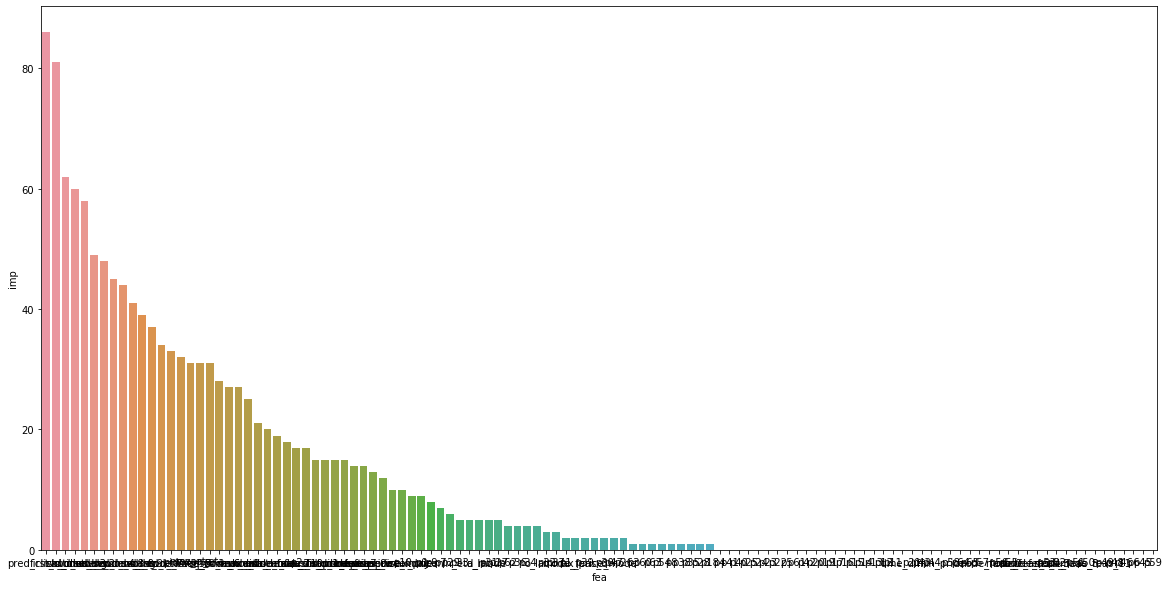

In [72]:
plt.figure(figsize=[20,10])
sns.barplot(x = 'fea', y ='imp',data = imp)

### 预测结果分析

除了对特征进行分析,我们再来分析每个类的预测结果,
- 我们发现0,4,6,8的recall很差,也就是说很多都没预测出来,可能需要通过很多其他的手段对其进行处理.

In [77]:
pred = lgb_model.predict(valid_x) 
df_analysis = pd.DataFrame()
df_analysis['sid']   = data[valid_index]['sid']
df_analysis['label'] = valid_y.values
df_analysis['pred']  = pred 

In [78]:
df_analysis['label'] = df_analysis['label'].astype(int)

In [79]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import accuracy_score,recall_score,precision_score
dic_ = df_analysis['label'].value_counts(normalize = True)
def get_weighted_fscore(y_pred, y_true):
    f_score = 0
    for i in range(12):
        yt = y_true == i
        yp = y_pred == i
        f_score += dic_[i] * f1_score(y_true=yt, y_pred= yp)
        print(i,dic_[i],f1_score(y_true=yt, y_pred= yp), precision_score(y_true=yt, y_pred= yp),recall_score(y_true=yt, y_pred= yp))
    print(f_score)
get_weighted_fscore(y_true =df_analysis['label'] , y_pred = df_analysis['pred'])

0 0.1897810218978102 0.5909090909090908 0.7222222222222222 0.5
1 0.10218978102189781 0.6666666666666666 0.625 0.7142857142857143
2 0.22627737226277372 0.8450704225352113 0.75 0.967741935483871
3 0.043795620437956206 0.0 0.0 0.0
4 0.029197080291970802 0.0 0.0 0.0
5 0.0948905109489051 0.8275862068965517 0.75 0.9230769230769231
6 0.014598540145985401 0.0 0.0 0.0
7 0.11678832116788321 0.7692307692307693 0.6521739130434783 0.9375
8 0.021897810218978103 0.0 0.0 0.0
9 0.12408759124087591 0.7567567567567567 0.7 0.8235294117647058
10 0.014598540145985401 0.0 0.0 0.0
11 0.021897810218978103 0.4 0.5 0.3333333333333333
0.6425206617355737


# 模型训练&提交

我们使用上面的最优的迭代次数作为我们模型的迭代次数进行线上结果的提交,该方案线上的成绩应该在0.680-0.690之间

In [90]:
all_train_x              = data[(data.req_time < '2018-12-01')][feature].reset_index(drop=True)
all_train_y              = data[(data.req_time < '2018-12-01')].click_mode.reset_index(drop=True)
all_train_x.shape, all_train_y.shape

((1000, 146), (1000,))

In [ ]:
print(lgb_model4.best_iteration_)
lgb_model4.n_estimators   = lgb_model.best_iteration_
lgb_model4.fit(all_train_x, all_train_y, categorical_feature=cate_feature)
print('fit over')
result                   = pd.DataFrame()
result['sid']            = data[test_index]['sid']
result['recommend_mode'] = lgb_model4.predict(test_x)
result['recommend_mode'] = result['recommend_mode'].astype(int)
print(len(result))
print(result['recommend_mode'].value_counts())
result[['sid', 'recommend_mode']].to_csv(path + 'sub/baseline.csv', index=False)